In [1]:
import utils
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
import time
import regex
from tqdm import tqdm_notebook as tqdm

root = "."


# Data Mining

First thing to do is to find the structure of the file. We can find a description in the "dblp.dtd" file and on the [website](http://dblp.uni-trier.de/faq/What+do+I+find+in+dblp+xml.html):

  - The children of the root represent the individual data records. There are two types of records: **publication records** and **person records**.
  - The xml files contains: article, inproceedings, proceedings, book, incollection, phdthesis, mastersthesis, www, person, data
  - A publication record can be:
    - article: An article from a journal or magazine.
    - inproceedings: A paper in a conference or workshop proceedings.
    - proceedings: The proceedings volume of a conference or workshop.
    - book: An authored monograph or an edited collection of articles.
    - incollection: A part or chapter in a monograph.
    - phdthesis: A PhD thesis.
    - mastersthesis: A Master's thesis. 
 - Most of the publication contain author/editor and title fields, that the ones we are interested in   


There are field used to represent the author
```
<www key="homepages/r/CJvanRijsbergen">
<author>C. J. van Rijsbergen</author>
<author>Cornelis Joost van Rijsbergen</author>
<author>Keith van Rijsbergen</author>
<title>Home Page</title>
<url>http://www.dcs.gla.ac.uk/~keith/</url>
</www>
```

Those field are called **person record**. An author can be used called by different name (John Doe, J.Doe, Doe) so those records group together the different representation of an author. We need to collect and build a mapping to map a name to the author id (key of the www field). Thanks to the website, we know that :

```
Person records always have the key-prefix "homepages/", 
the record level tag is always "www", and they always 
contain a title element with the text content "Home Page"
```


Also all the name are unique. If there are 2 homonyms, an id is appened to the name

We collect titles and authors of each publication (if 2 authors participate at the same publication, it gives one publication to each authors).

In the meantime we collect the person description (all name and id). At the end we will be able to merge the publication of J. Doe and John Doe if both map to the same author

# Collect the data

To collect the data we use the class **xml_parser**. The function *collect_data()* iterates over the file and collects the mapping:
  - author_name -> author_id
  - author_name -> titles

finally it merges the 2 dicts together to create the:
  - author_id -> titles

the function saves the 3 dictionnaries in the same folder as the original data



Uncomment the last line to parse the file, can take a few minutes (around 15min on my computer)

In [3]:
from importlib import reload
import xml_parser
reload(xml_parser)
from xml_parser import Xml_parser

#Xml_parser = Xml_parser().collect_data("../pmi_data")

2232it [00:00, 22314.28it/s]

Start collecting


51633859it [24:59, 34444.36it/s]


Saving author_publication in  ../pmi_data/authorName_publication.p


  1%|▏         | 26105/1924181 [00:00<00:07, 261046.51it/s]

Saving author_to_authorID in  ../pmi_data/authorName_to_authorID.p
Saving authorID_to_publications in  ../pmi_data/authorID_to_publications.p
merge authorID and publication


100%|██████████| 1924181/1924181 [00:18<00:00, 106173.32it/s]


Saving author_publication in  ../pmi_data/authorName_publication.p
Saving author_to_authorID in  ../pmi_data/authorName_to_authorID.p
Saving authorID_to_publications in  ../pmi_data/authorID_to_publications.p


# Observation of the data

Load the author-> publication dataset and plot the distribution of publications

In [2]:
authorID_to_titles = utils.load_pickle("../pmi_data/authorID_to_publications.p")

In [3]:
authorID_to_count = {k:len(v['titles']) for k,v in tqdm(authorID_to_titles.items())}

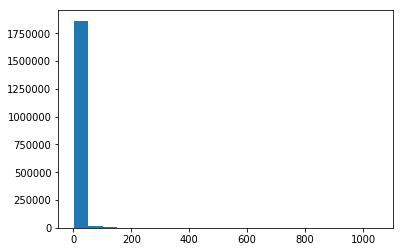

Max 1018, min 1


In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
data = list(authorID_to_count.values())
binwidth = int((max(data)-min(data))/20)
ax.hist(data,
       bins=range(min(data), max(data) + binwidth, binwidth))
plt.show()
print("Max {0}, min {1}".format(max(data), min(data)))

We can observe that most of the authors have between 1 and 50 publications. A few author have around 50 and 200 publications which seems reasanable. Howerwer, the maximum is mode than 1000 which is to much. Let's investigate the outliers



[Here](http://dblp.uni-trier.de/faq/Why+are+some+names+followed+by+a+four+digit+number.html) we can found some very important informations about names :
- In the case of homonymous names, dblp aims to use the name version **without any suffix** (number after the name) as a **person disambiguation page**, and not as the **bibliography of an actual person**. Any publication listed on such a page has not been assigned to an actual author (i.e., someone with a homonym suffix number) yet.
- Since in the **early days of dblp author name versions without a homonym suffix number had been used as normal bibliography pages**, too, there can still be found examples of homonymous names where the entity without any suffix is still considered to model the bibliography of an actual person. Removing the last remnants of these examples by giving explicit suffix numbers is currently a work in progress at dblp.
- Currently, **you could use the following rule of thumb to distinguish most cases adequately:**:
    - If a person page has a homonymous name variant using the suffix "0001", and the page carries no additional person information like a home page link or an affiliation note => Drop it (disambiguation page) 
    - Otherwise :
        - if the earliest homonym name starts with suffix "0002"
        - there are additional pieces of author information given) 
        - The number of publication is between 0 and 50
        
        =>then the page is likely to be intended to be the profile of an actual person


After investigation the notation of the data is quite messy. They are not consistent with the notification of the id: homepages/c/LeiChen0018, homepages/c/LeiChen-17, homepages/c/LeiChen18

So let's just try to apply the rule: if infos about the author ("note" or "url") keep it

Even by applying those rule it doesn't seems to remove all the disambiguation pages. 
To keep it simple we will use a reasonable number of publications as threshold.

Observe the proportion of author above a limit:


In [5]:
def get_author_with_more_than(data, max_):
    more_than = [k for k, v in data.items() if v >max_]
    print("Authors with more than {0}: {1} ({2}%)".format(max_, len(more_than), round(len(more_than)/len(data)*100,4)))
get_author_with_more_than(authorID_to_count, 1010)
get_author_with_more_than(authorID_to_count, 500) 
get_author_with_more_than(authorID_to_count, 300)
get_author_with_more_than(authorID_to_count, 200)
get_author_with_more_than(authorID_to_count, 190)
get_author_with_more_than(authorID_to_count, 50)

Authors with more than 1010: 2 (0.0001%)
Authors with more than 500: 149 (0.0079%)
Authors with more than 300: 698 (0.0369%)
Authors with more than 200: 2002 (0.1059%)
Authors with more than 190: 2249 (0.1189%)
Authors with more than 50: 26952 (1.4254%)


We will use 190 as a threshold. We won't remove to much authors (0.1%) and above 190 publications it seems too much

In [6]:
authors_to_titles_clean= {author:v['titles'] for author, v in tqdm(authorID_to_titles.items()) if len(v['titles'])<=190}

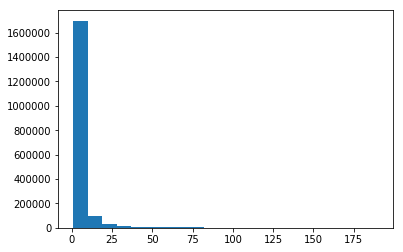

Max 190, min 1


In [7]:
authorID_to_count = {k:len(titles) for k,titles in tqdm(authors_to_titles_clean.items())}
fig = plt.figure()
ax = fig.add_subplot(111)
data = list(authorID_to_count.values())
binwidth = int((max(data)-min(data))/20)
ax.hist(data,
       bins=range(min(data), max(data) + binwidth, binwidth))
plt.show()
print("Max {0}, min {1}".format(max(data), min(data)))

In [10]:
utils.pickle_data(authors_to_titles_clean, "../pmi_data/authorID_to_publications_clean.p")

This plot is reasonable. Let's move on to the next step (see notebook 2.Topics)